<img src="https://hilpisch.com/tpq_logo.png" alt="The Python Quants" width="35%" align="right" border="0"><br>

# Reinforcement Learning for Finance

**Chapter 05 &mdash; Generated Data**

&copy; Dr. Yves J. Hilpisch

<a href="https://tpq.io" target="_blank">https://tpq.io</a> | <a href="https://twitter.com/dyjh" target="_blank">@dyjh</a> | <a href="mailto:team@tpq.io">team@tpq.io</a>

## Simple Example

## Introduction to Generated Financial Data

This notebook introduces **Generative Adversarial Networks (GANs)** for creating synthetic financial data - a revolutionary approach that goes beyond traditional simulation methods.

### Why Generate Financial Data?

**1. Data Scarcity Problem:**
- Real financial data is limited by time (markets only generate so much history)
- Rare events (crashes, bubbles) are underrepresented in historical data
- Private/proprietary datasets are expensive and restricted

**2. Privacy and Compliance:**
- Generate realistic data without exposing actual trading positions
- Create public datasets for research without regulatory concerns
- Enable stress testing with realistic but fictional scenarios

**3. Advanced Training:**
- Unlimited training data for machine learning models
- Better representation of tail events and extreme scenarios
- Data augmentation that preserves statistical properties

### GANs vs. Traditional Simulation:

**Traditional Approach (Notebook 4):**
- Uses mathematical models (e.g., Ornstein-Uhlenbeck)
- Requires parameter specification
- Limited to known functional forms

**GAN Approach (This Notebook):**
- Learns directly from data
- No assumption about underlying distribution
- Can capture complex, unknown patterns
- More flexible and data-driven

### Learning Objectives:
- Understand GAN architecture (Generator vs. Discriminator)
- Learn to generate realistic financial time series
- Validate synthetic data quality using statistical tests
- Apply GANs to real market data (Gold ETF returns)

In [1]:
import os
import numpy as np
import pandas as pd
from pylab import plt, mpl

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers.legacy import Adam
from sklearn.preprocessing import StandardScaler

In [3]:
plt.style.use('seaborn-v0_8')
mpl.rcParams['figure.dpi'] = 300
mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['font.family'] = 'serif'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [4]:
x = np.linspace(-2, 2, 500)

In [5]:
def f(x):
    return x ** 3

### Starting Simple: Learning to Generate a Mathematical Function

Before tackling complex financial data, let's understand GANs with a simple example: **learning to generate a cubic function**.

**The Target Function:**
- `f(x) = x³` over the range [-2, 2]
- 500 sample points for training
- Known ground truth for easy validation

**Why Start Simple?**
- Easy to visualize results
- Clear success metrics
- Understand GAN mechanics without financial complexity
- Debug issues in controlled environment

**Data Preprocessing:**
- **Standardization**: GANs work better with normalized data (mean=0, std=1)
- **Shape management**: Reshape for neural network compatibility
- **Visualization**: Compare original vs. normalized data

In [6]:
y = f(x)

In [7]:
scaler = StandardScaler()

In [8]:
y_ = scaler.fit_transform(y.reshape(-1, 1))

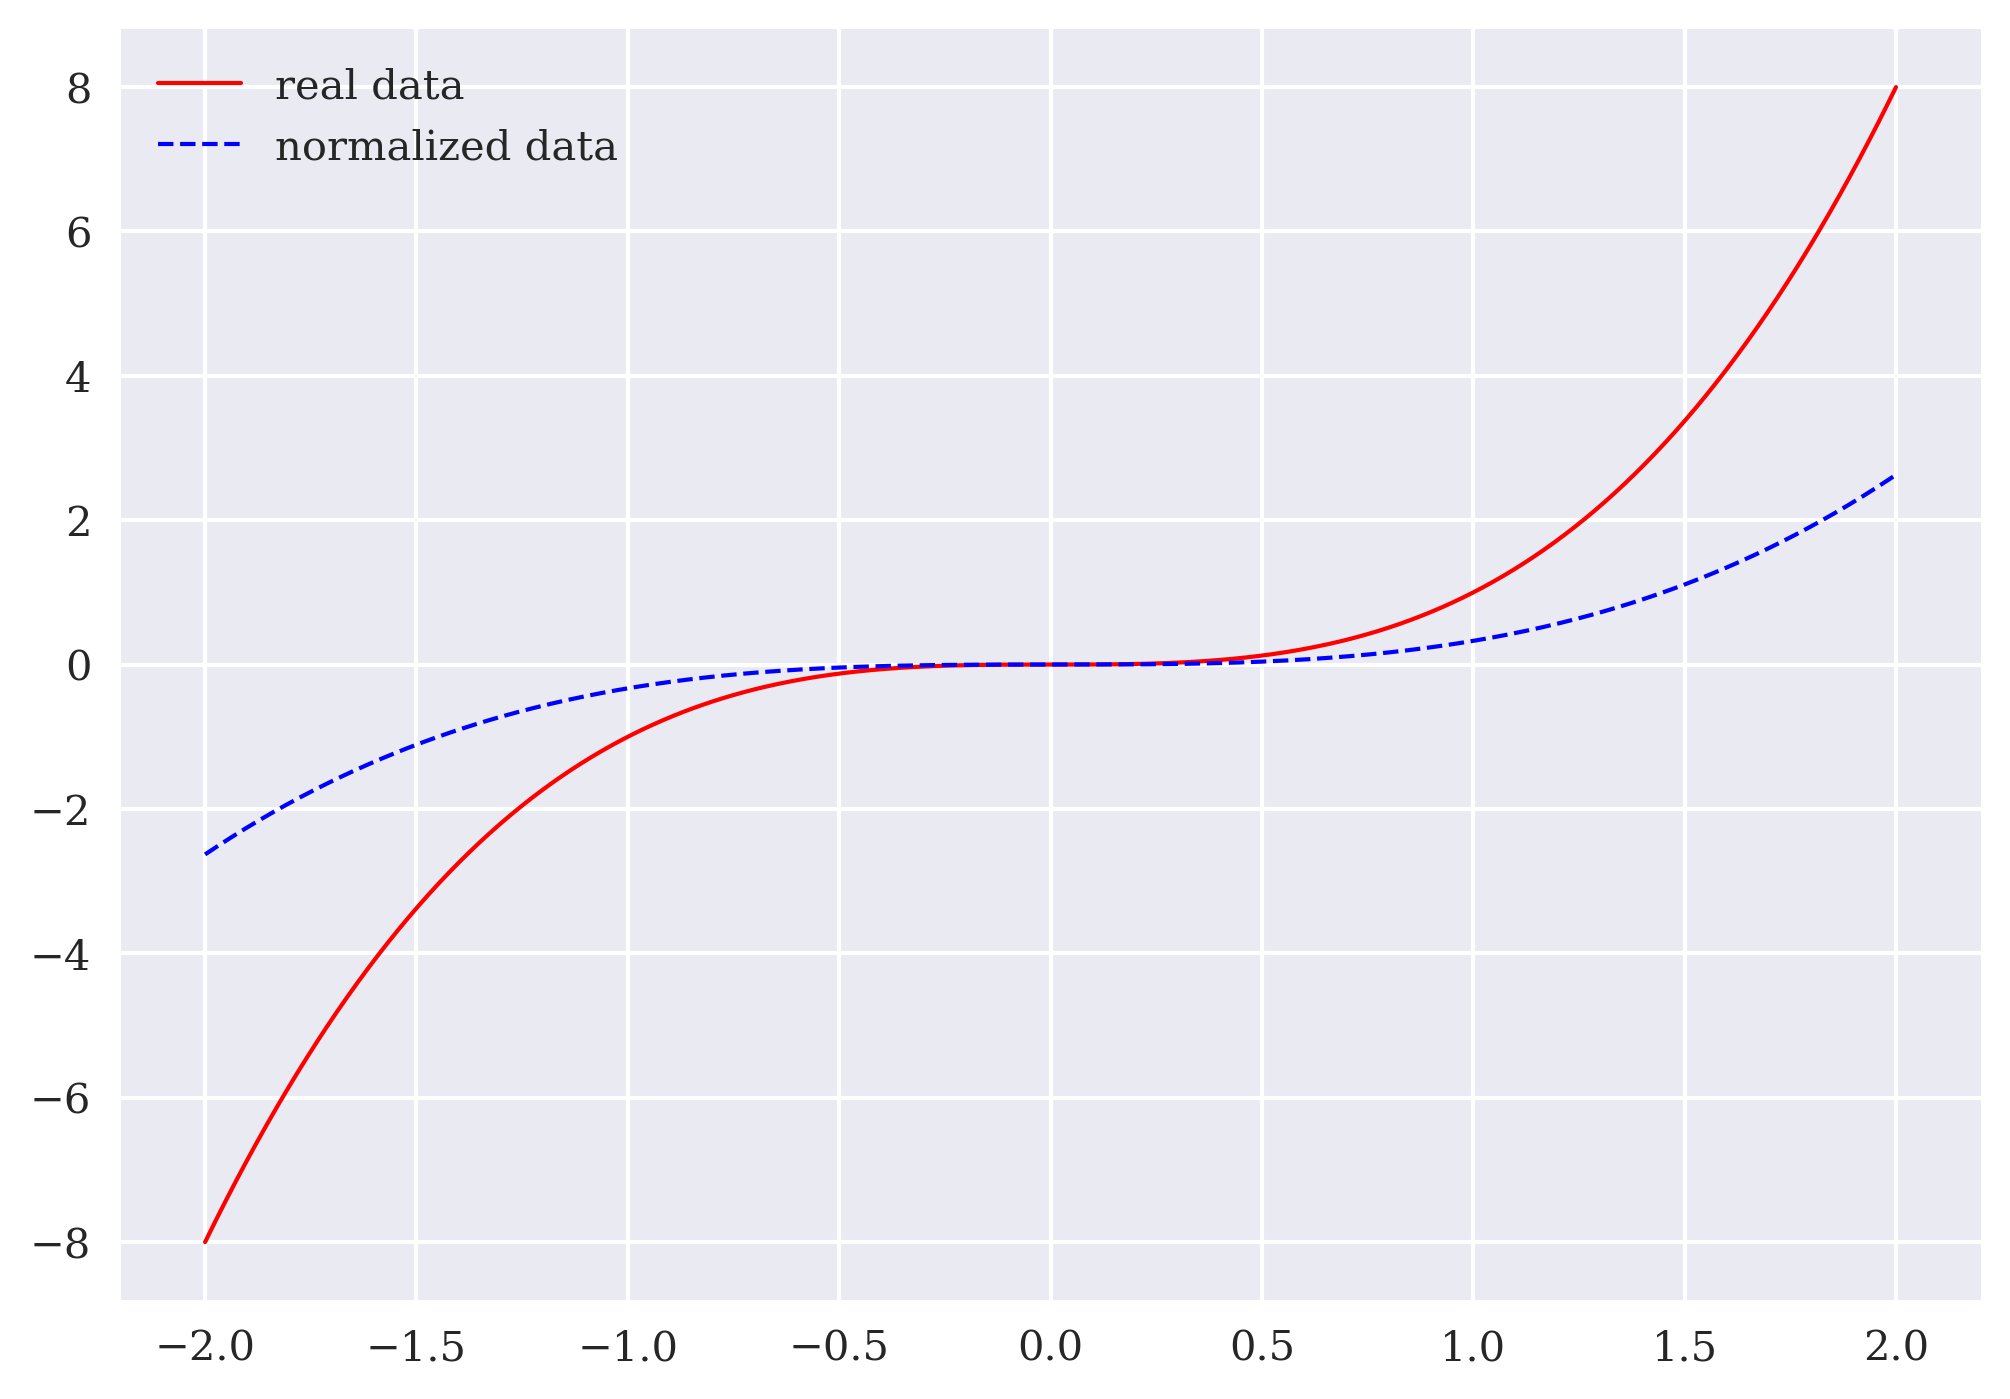

In [9]:
plt.plot(x, y, 'r', lw=1.0,
         label='real data')
plt.plot(x, y_, 'b--', lw=1.0,
         label='normalized data')
plt.legend();

### Model Training

In [10]:
def create_generator(hu=32):
    model = Sequential()
    model.add(Dense(hu, activation='relu', input_dim=1))
    model.add(Dense(hu, activation='relu'))
    model.add(Dense(1, activation='linear'))
    return model

### Understanding GAN Architecture

**Generative Adversarial Networks consist of two competing neural networks:**

**1. Generator Network:**
- **Input**: Random noise (latent space)
- **Output**: Synthetic data that mimics real data
- **Goal**: Fool the discriminator into thinking synthetic data is real
- **Architecture**: Dense layers with ReLU activation, linear output

**2. Discriminator Network:**
- **Input**: Either real or synthetic data
- **Output**: Probability that input is real (0-1)
- **Goal**: Correctly classify real vs. synthetic data
- **Architecture**: Dense layers with ReLU, sigmoid output for binary classification

**The Adversarial Game:**
- **Generator** tries to create increasingly realistic fake data
- **Discriminator** tries to get better at detecting fakes
- **Nash Equilibrium**: Generator creates perfect fakes, discriminator can't tell the difference
- **Result**: High-quality synthetic data that preserves statistical properties

In [11]:
def create_discriminator(hu=32):
    model = Sequential()
    model.add(Dense(hu, activation='relu', input_dim=1))
    model.add(Dense(hu, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=Adam(),
                  metrics=['accuracy'])
    return model

In [12]:
def create_gan(generator, discriminator, lr=0.001):
    discriminator.trainable = False
    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    model.compile(loss='binary_crossentropy',
                  optimizer=Adam(learning_rate=lr))
    return model

### GAN Training Setup

**The Combined GAN Model:**
- **Discriminator frozen**: During generator training, discriminator weights don't update
- **Generator learns**: How to fool the discriminator
- **Sequential architecture**: Noise → Generator → Discriminator → Probability

**Key Training Concepts:**
- **Adversarial loss**: Binary cross-entropy for the classification game
- **Learning rates**: Different rates for generator and discriminator balance
- **Training alternation**: Train discriminator, then generator, repeat

**Critical Balance:**
- **Too strong discriminator**: Generator can't learn (always loses)
- **Too weak discriminator**: Generator doesn't improve (easy to fool)
- **Just right**: Both networks improve together, pushing each other to excellence

In [13]:
generator = create_generator()
discriminator = create_discriminator()
gan = create_gan(generator, discriminator, 0.0001)

In [14]:
from numpy.random import default_rng

In [15]:
rng = default_rng(seed=100)

In [16]:
def train_models(y_, epochs, batch_size):
    for epoch in range(epochs):
        # Generate synthetic data
        noise = rng.normal(0, 1, (batch_size, 1))
        synthetic_data = generator.predict(noise, verbose=False)

        # Train discriminator
        real_data = y_[rng.integers(0, len(y_), batch_size)]
        discriminator.train_on_batch(real_data, np.ones(batch_size))
        discriminator.train_on_batch(synthetic_data,
                                     np.zeros(batch_size))

        # Train generator
        noise = rng.normal(0, 1, (batch_size, 1))
        gan.train_on_batch(noise, np.ones(batch_size))

        # Print progress
        if epoch % 1000 == 0:
            print(f'Epoch: {epoch}')
    return real_data, synthetic_data

### The GAN Training Process

**Training Loop Breakdown:**

**Step 1: Train Discriminator**
- **Real data batch**: Sample from actual f(x) = x³ data
- **Synthetic data batch**: Generate using current generator
- **Real labels**: Train discriminator to output 1 for real data
- **Fake labels**: Train discriminator to output 0 for synthetic data

**Step 2: Train Generator**
- **Generate new synthetic data**: Using random noise
- **Adversarial training**: Train generator to make discriminator output 1
- **Generator goal**: Create data so good that discriminator thinks it's real

**Training Dynamics:**
- **Epochs**: Multiple passes through the dataset
- **Batch size**: Process small chunks for stable training
- **Progress monitoring**: Track how well each network is performing

**Expected Progression:**
- **Early**: Generator produces random noise, discriminator easily detects fakes
- **Middle**: Generator improves, discriminator gets better at detection
- **Convergence**: Generator creates realistic data, discriminator struggles to differentiate

In [17]:
%%time
real_data, synthetic_data = train_models(y_, epochs=5001, batch_size=32)

Epoch: 0
Epoch: 1000
Epoch: 2000
Epoch: 3000
Epoch: 4000
Epoch: 5000
CPU times: user 2min 1s, sys: 13.6 s, total: 2min 14s
Wall time: 2min 6s


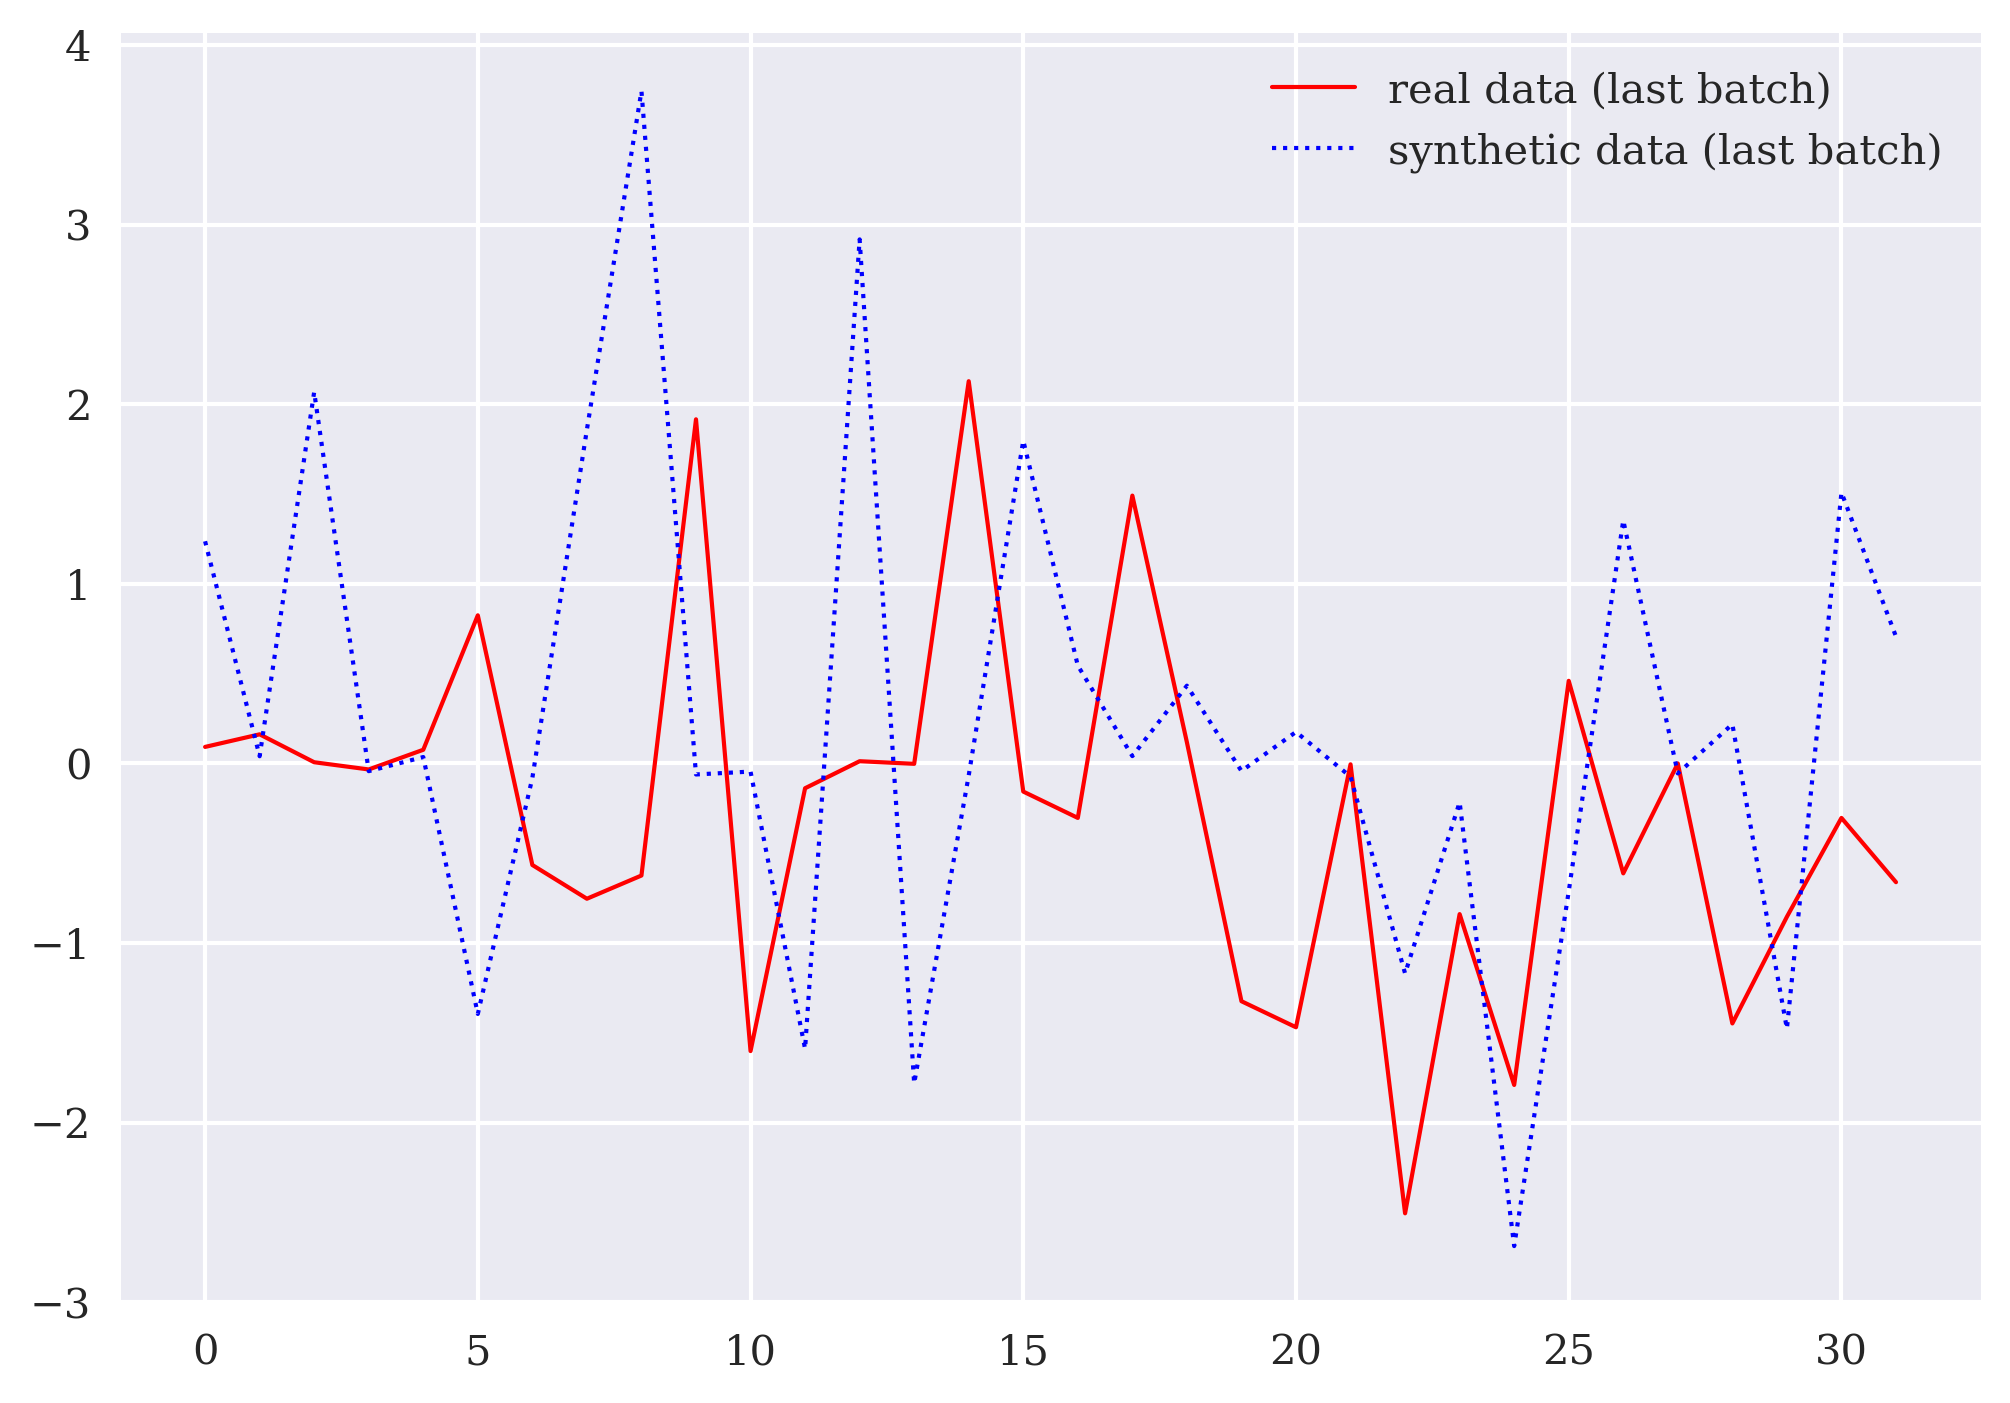

In [18]:
plt.plot(real_data, 'r', lw=1.0,
         label='real data (last batch)')
plt.plot(synthetic_data, 'b:', lw=1.0,
         label='synthetic data (last batch)')
plt.legend();

### Evaluating Training Results

**Comparing Final Batches:**
This visualization shows the last batch of real data (red) vs. synthetic data (blue) from training. Success indicators:
- **Similar patterns**: Synthetic data follows same general trends as real data
- **Comparable ranges**: Generated values span similar min/max bounds
- **Statistical similarity**: Moments (mean, variance) should be close

**Quality Assessment:**
- **Visual inspection**: Do the curves look similar?
- **Statistical comparison**: Are distributions comparable?
- **Error metrics**: How close are the generated values?

In [19]:
data = pd.DataFrame({'real': y}, index=x)

In [20]:
N = 5
for i in range(N):
    noise = rng.normal(0, 1, (len(y), 1))
    synthetic_data = generator.predict(noise, verbose=False)
    data[f'synth_{i:02d}'] = scaler.inverse_transform(synthetic_data)

### Generating Multiple Synthetic Datasets

**Creating Dataset Variations:**
Now we generate 5 different synthetic versions of our cubic function using the trained generator:

**Process:**
1. **Random noise**: Each generation uses different random input
2. **Generator inference**: Trained model transforms noise into synthetic data
3. **Inverse scaling**: Convert normalized output back to original scale
4. **Comparison**: Store alongside real data for analysis

**Purpose:**
- **Variability assessment**: How consistent is the generator?
- **Quality evaluation**: Do all versions look realistic?
- **Statistical validation**: Are distributions preserved across generations?
- **Practical application**: Demonstrate unlimited data generation capability

In [21]:
data.describe().round(3)

real  synth_00  synth_01  synth_02  synth_03  synth_04
count  500.000   500.000   500.000   500.000   500.000   500.000
mean    -0.000    -0.039    -0.038     0.175    -0.009    -0.022
std      3.045     2.884     3.013     2.881     3.017     3.151
min     -8.000   -10.775   -13.484    -9.209    -8.262   -10.524
25%     -1.000    -0.980    -1.005    -0.630    -0.837    -0.854
50%     -0.000    -0.095    -0.077    -0.021    -0.095    -0.022
75%      1.000     0.754     0.904     1.131     0.999     1.082
max      8.000    11.857    11.569    10.124     9.912     8.738

In [22]:
((data.apply(np.sort)['real'] -
  data.apply(np.sort)['synth_00']) ** 2).mean()

0.16332014352347354

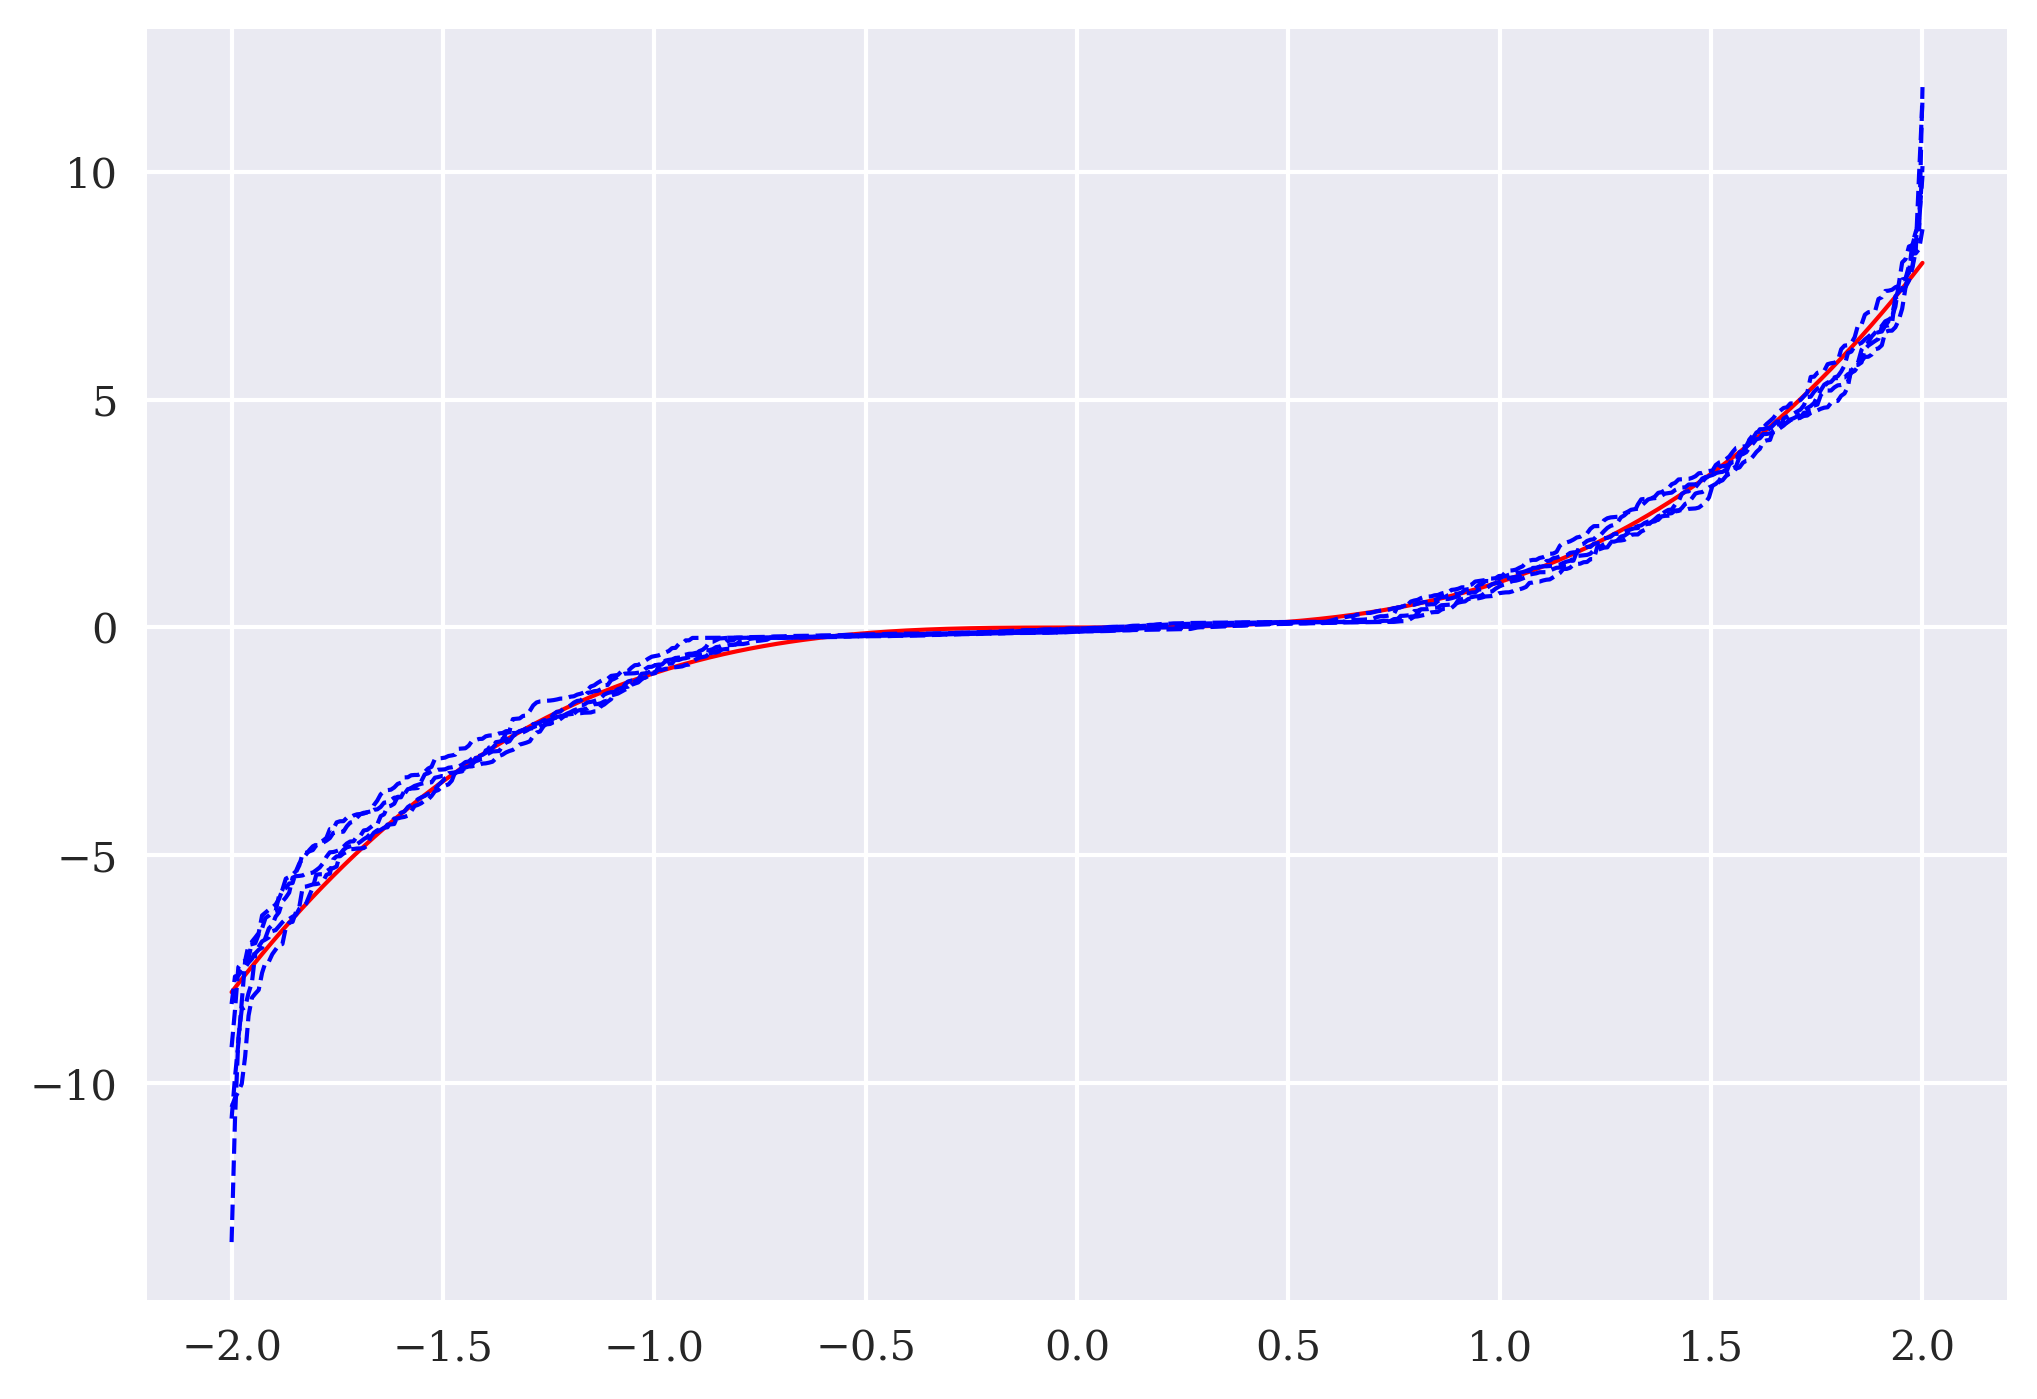

In [23]:
data.apply(np.sort).plot(style=['r'] + N * ['b--'], lw=1, legend=False);

**Quantitative Validation:**

**1. Descriptive Statistics:** The `.describe()` output shows statistical moments (mean, std, quartiles) for real vs. synthetic data. Good GANs preserve these statistical properties.

**2. Mean Squared Error:** Measures average squared difference between sorted real and synthetic values. Lower values indicate better replication of the data distribution.

**3. Distribution Visualization:** Plotting sorted values shows whether the generator captures the full range and shape of the original distribution. Perfect alignment would show overlapping lines.

## Financial Example

In [24]:
raw = pd.read_csv('https://certificate.tpq.io/rl4finance.csv',
                 index_col=0, parse_dates=True).dropna()

In [25]:
rets = raw['GLD'].iloc[-2 * 252:]
rets = np.log((rets / rets.shift(1)).dropna())
rets = rets.values

### Applying GANs to Real Financial Data

**Moving to Finance: Gold ETF (GLD) Returns**

Now we apply our GAN approach to **real financial time series**:

**Data Selection:**
- **Asset**: Gold ETF (GLD) - represents gold price movements
- **Time period**: Last 2 years (2×252 = 504 trading days)
- **Feature**: Logarithmic returns (daily price changes)

**Why Gold Returns?**
- **High volatility**: Challenging for GANs to replicate
- **Non-normal distribution**: Fat tails and skewness
- **Financial relevance**: Important for portfolio diversification
- **Realistic complexity**: Real-world financial characteristics

**Data Preprocessing:**
- **Log returns**: `log(price[t] / price[t-1])` for better statistical properties
- **Standardization**: Normalize for neural network training
- **Shape formatting**: Prepare for GAN architecture

In [26]:
scaler = StandardScaler()

In [27]:
rets_ = scaler.fit_transform(rets.reshape(-1, 1))

In [28]:
rng = default_rng(100)
tf.random.set_seed(100)

### Configuring GANs for Financial Data

**Architecture Adjustments for Finance:**

**1. Network Size:**
- **Hidden units**: Increased to 24 (from 32) for financial complexity
- **Depth**: Same 2-layer architecture but optimized for returns data
- **Capacity**: Balanced between underfitting and overfitting

**2. Financial-Specific Considerations:**
- **Return characteristics**: Capturing volatility clustering and fat tails
- **Time series properties**: Preserving temporal dependencies
- **Stationarity**: Returns are more stationary than prices

**3. Training Parameters:**
- **Learning rate**: Conservative 0.0001 for stable financial data generation
- **Batch size**: 32 for good gradient estimates
- **Epochs**: 5001 for thorough training on complex financial patterns

In [29]:
generator = create_generator(hu=24)
discriminator = create_discriminator(hu=24)
gan = create_gan(generator, discriminator, lr=0.0001)

In [30]:
%time rd, sd = train_models(y_=rets_, epochs=5001, batch_size=32)

Epoch: 0
Epoch: 1000
Epoch: 2000
Epoch: 3000
Epoch: 4000
Epoch: 5000
CPU times: user 2min 1s, sys: 14.1 s, total: 2min 16s
Wall time: 2min 6s


In [31]:
data = pd.DataFrame({'real': rets})

### Generating Synthetic Financial Returns

**Creating Multiple Financial Scenarios:**

**Scale of Generation:**
- **25 synthetic datasets**: Much larger scale than simple example
- **Same length**: Each synthetic series matches original data length
- **Statistical validation**: More samples for robust testing

**Financial Applications:**
- **Risk modeling**: Multiple scenarios for Value-at-Risk calculations
- **Stress testing**: Extreme scenarios for portfolio testing
- **Monte Carlo simulation**: Input for pricing and risk models
- **Machine learning training**: Augmented datasets for algorithm training

**Quality Expectations:**
- **Return distribution**: Similar mean, volatility, skewness, kurtosis
- **Temporal properties**: Realistic volatility clustering
- **Tail behavior**: Appropriate extreme value representation

In [32]:
N = 25

In [33]:
for i in range(N):
    noise = np.random.normal(0, 1, (len(rets_), 1))
    synthetic_data = generator.predict(noise, verbose=False)
    data[f'synth_{i:02d}'] = scaler.inverse_transform(
                                            synthetic_data)

In [34]:
res = data.describe().round(4)
res.iloc[:, :5]

real  synth_00  synth_01  synth_02  synth_03
count  503.0000  503.0000  503.0000  503.0000  503.0000
mean     0.0002   -0.0008   -0.0003    0.0001    0.0002
std      0.0090    0.0088    0.0083    0.0084    0.0085
min     -0.0302   -0.0287   -0.0231   -0.0280   -0.0279
25%     -0.0052   -0.0062   -0.0055   -0.0052   -0.0050
50%      0.0003   -0.0003    0.0003    0.0014    0.0009
75%      0.0054    0.0044    0.0047    0.0047    0.0049
max      0.0316    0.0335    0.0280    0.0272    0.0332

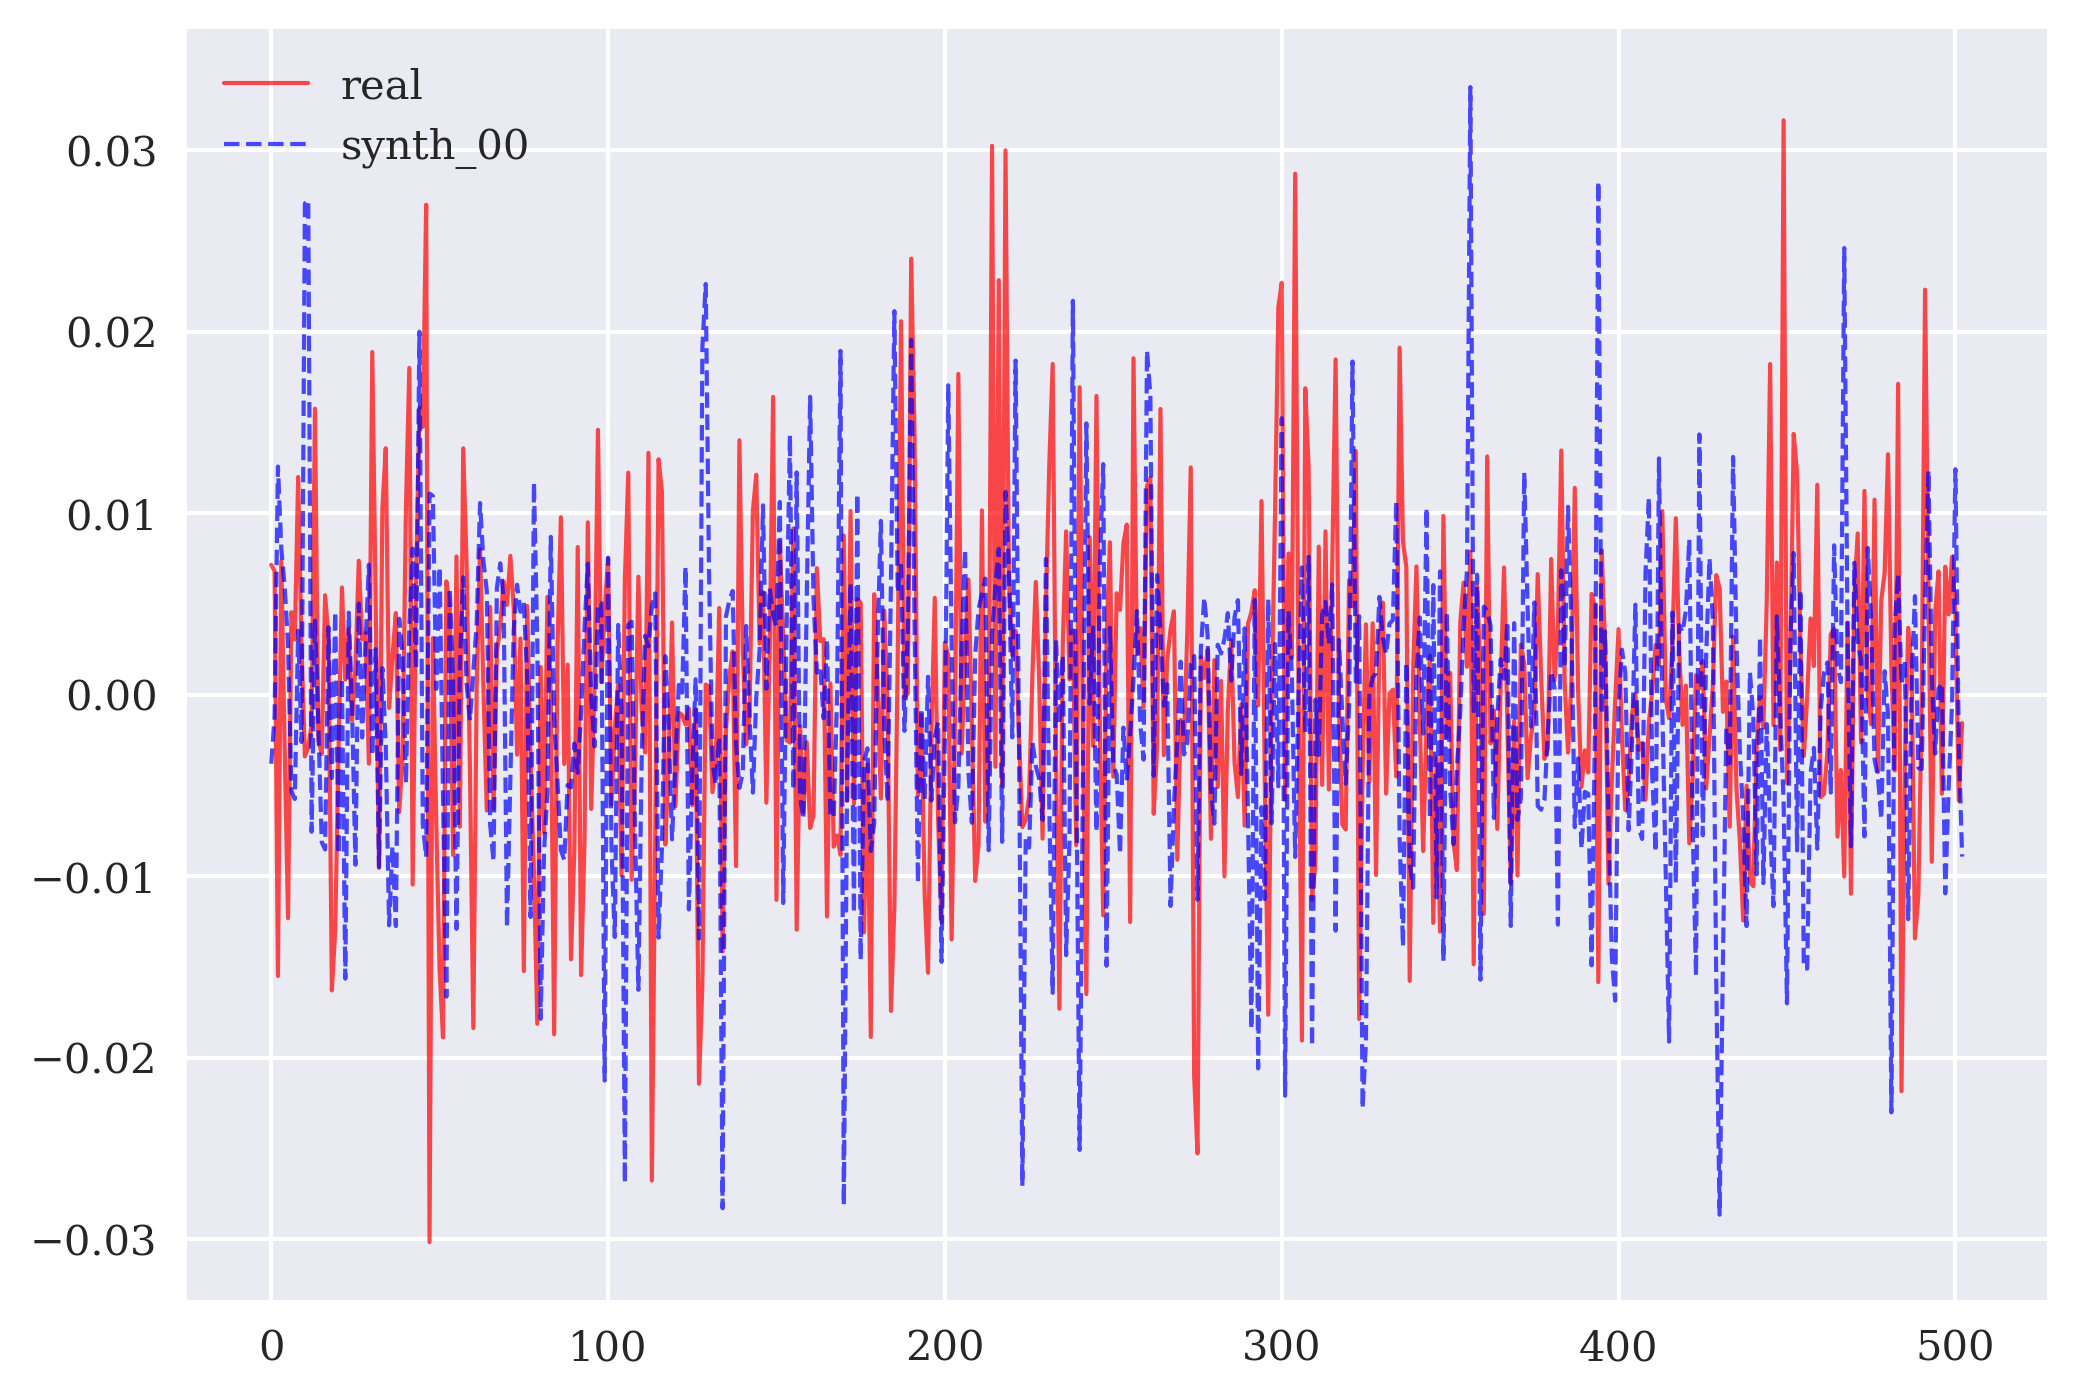

In [35]:
data.iloc[:, :2].plot(style=['r', 'b--', 'b--'], lw=1, alpha=0.7);

### Comprehensive Financial Data Validation

**Multiple Validation Approaches:**

**1. Time Series Comparison:**
- **Real vs. Synthetic**: Direct comparison of return patterns
- **Visual similarity**: Do synthetic returns "look" like financial data?

**2. Distribution Analysis:**
- **Histograms**: Compare probability distributions
- **Q-Q plots**: Check if distributions match across quantiles
- **Moments**: Statistical measures (mean, variance, skewness, kurtosis)

**3. Cumulative Performance:**
- **Price reconstruction**: Convert returns back to price paths using `exp(cumsum(returns))`
- **Multiple scenarios**: Blue lines show various synthetic price paths
- **Average performance**: Green line shows mean of synthetic scenarios
- **Benchmark comparison**: Red line shows actual gold performance

**Financial Interpretation:**
This shows whether synthetic data can reproduce realistic investment scenarios and price evolution patterns.

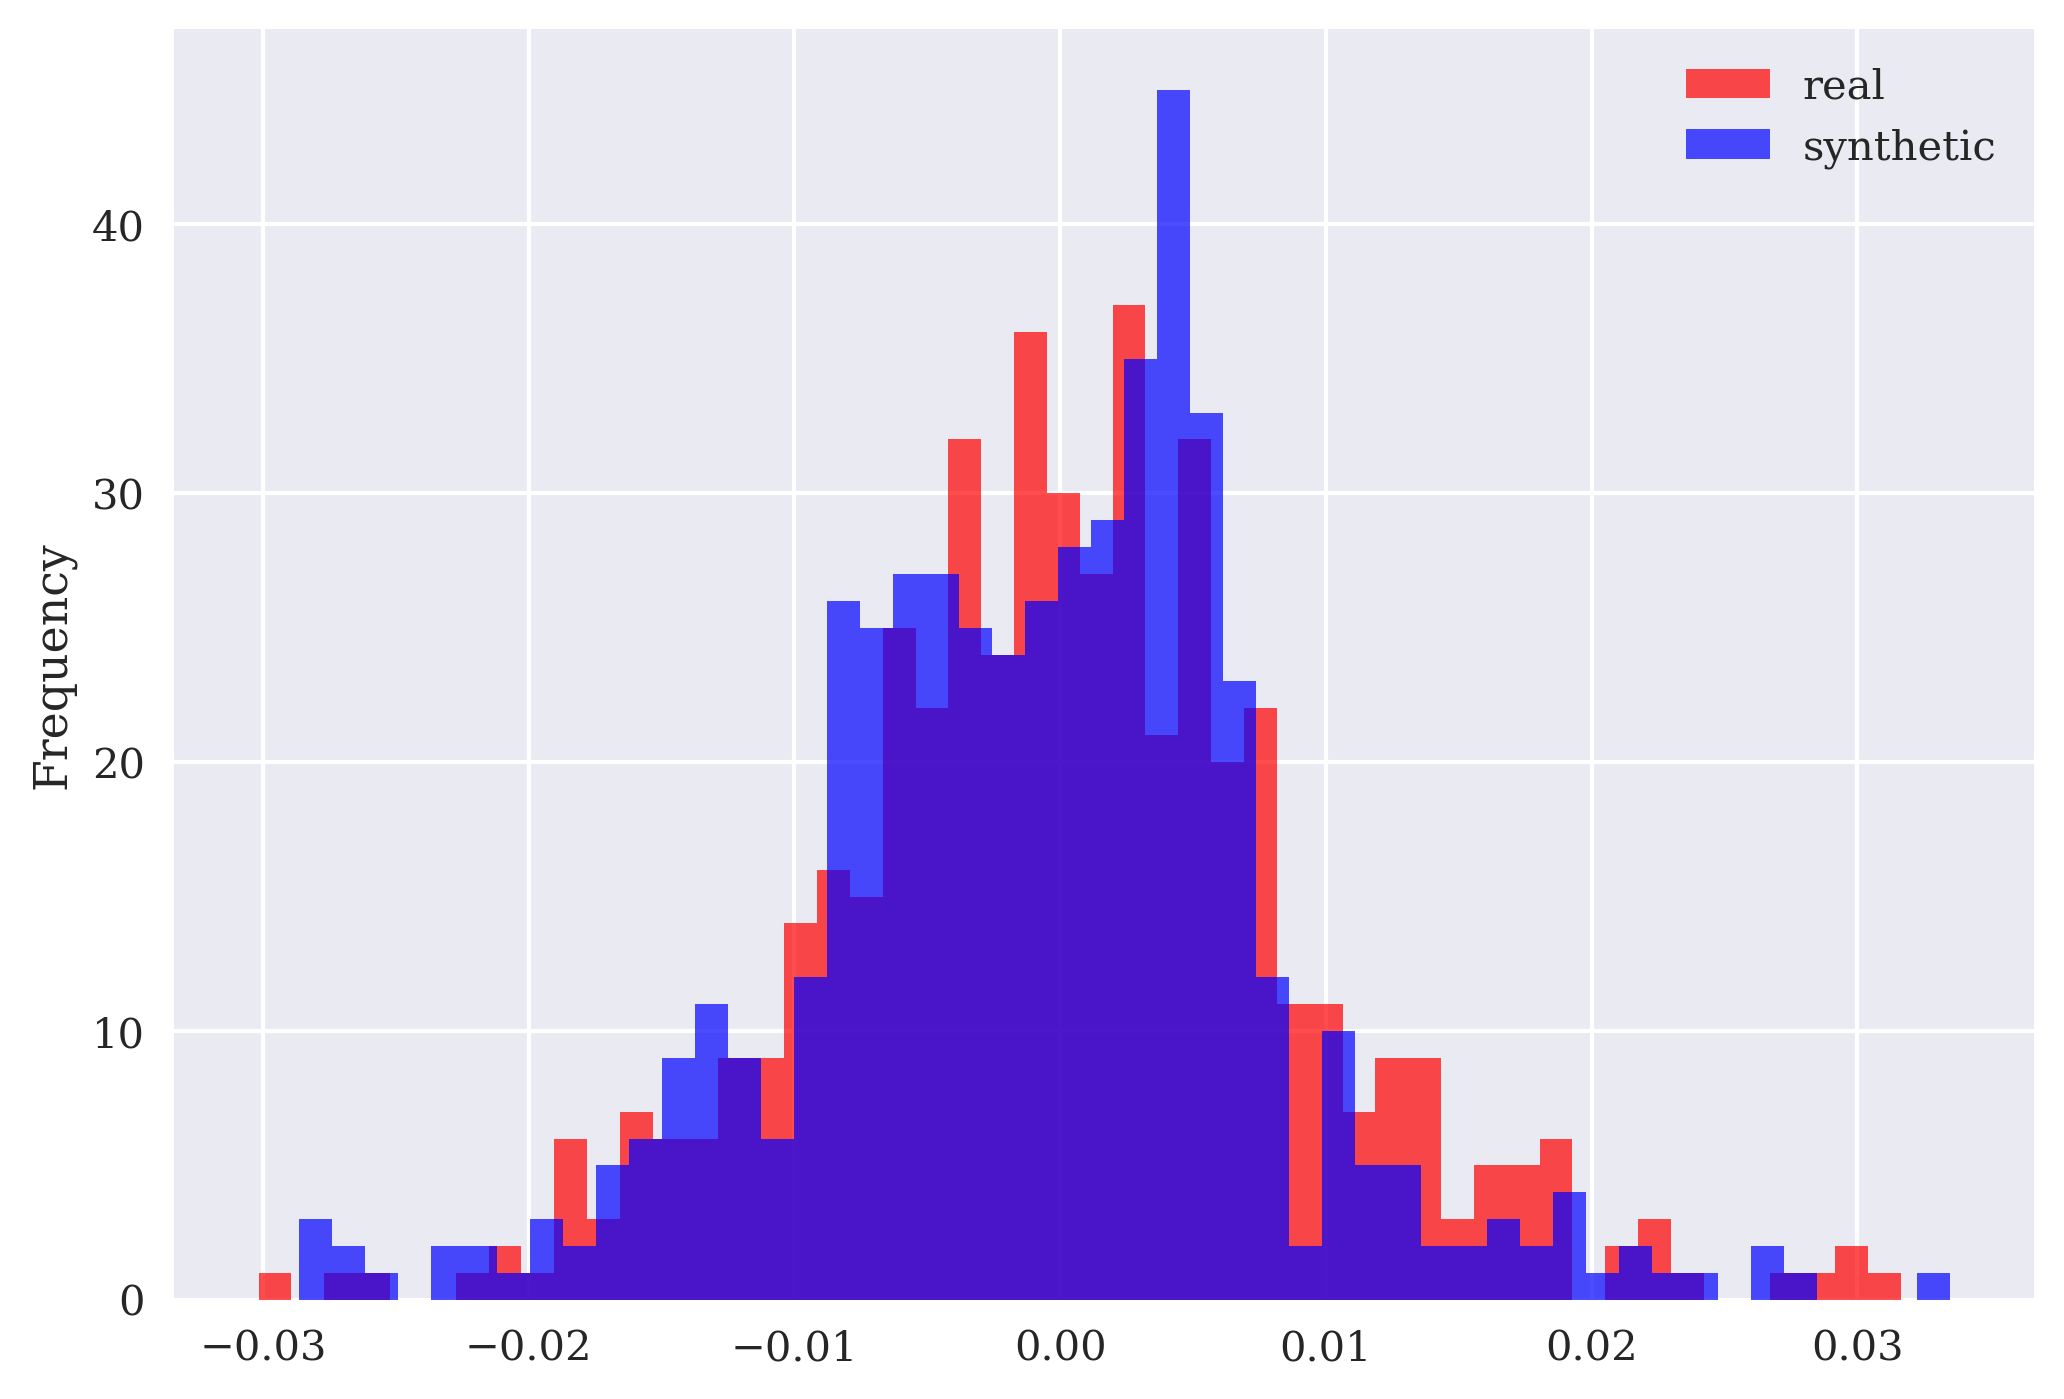

In [36]:
data['real'].plot(kind='hist', bins=50, label='real',
                  color='r', alpha=0.7)
data['synth_00'].plot(kind='hist', bins=50, alpha=0.7,
                  label='synthetic', color='b', sharex=True)
plt.legend();

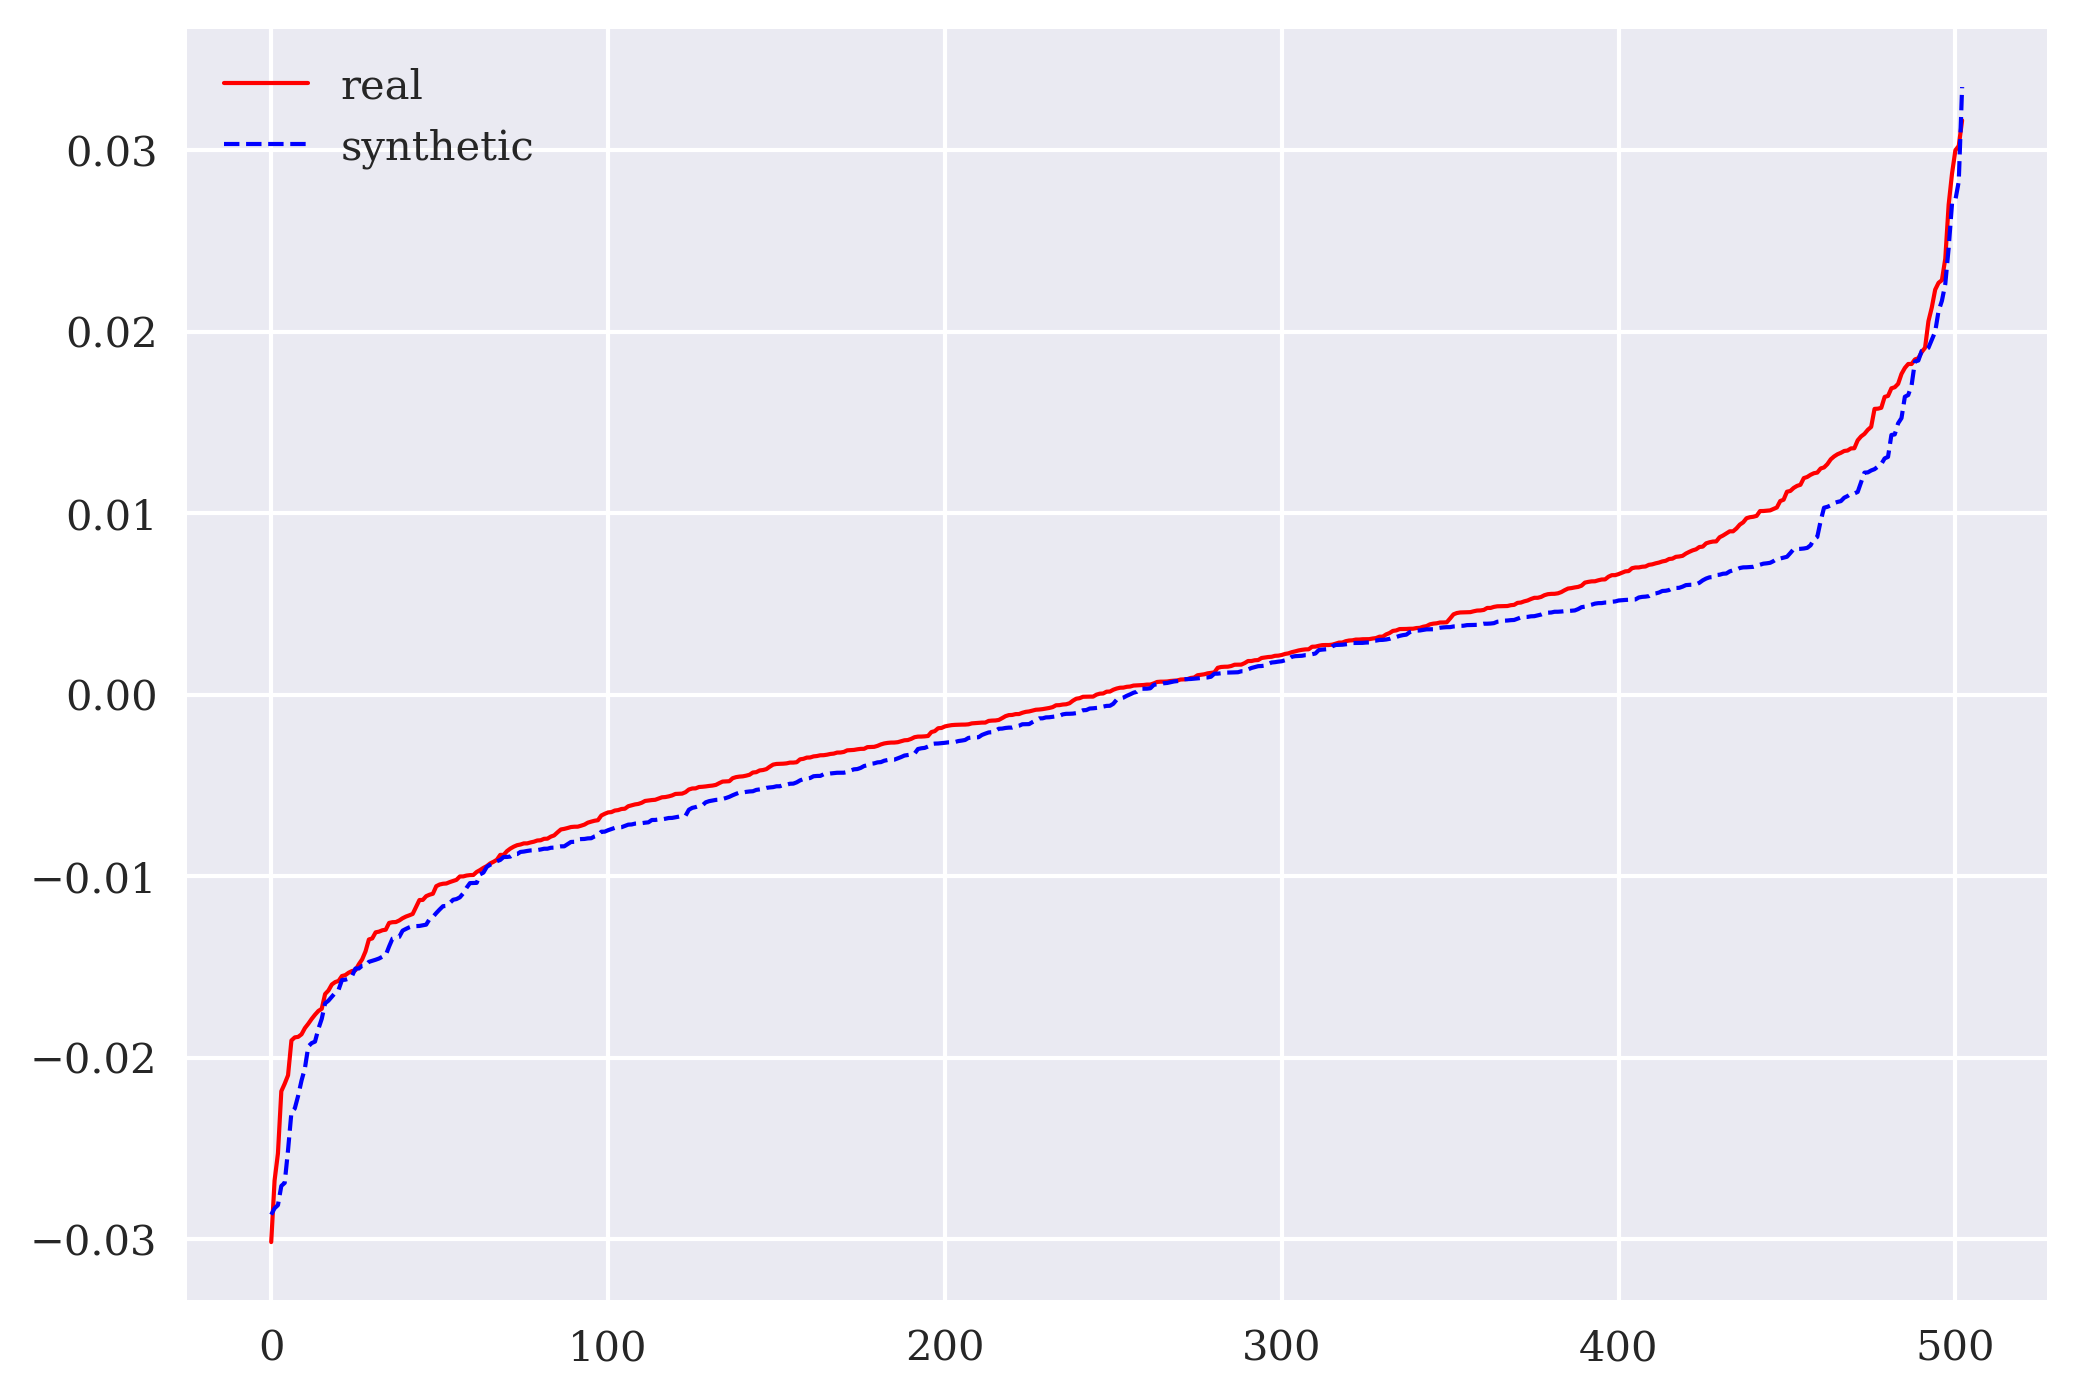

In [37]:
plt.plot(np.sort(data['real']), 'r', lw=1.0, label='real')
plt.plot(np.sort(data['synth_00']), 'b--', lw=1.0, label='synthetic')
plt.legend();

### Rigorous Statistical Validation

**Kolmogorov-Smirnov (KS) Test:**

**What it tests:**
- **Null hypothesis**: Synthetic and real data come from the same distribution
- **Test statistic**: Maximum difference between cumulative distribution functions
- **P-value interpretation**: 
  - **p > 0.05**: Cannot reject null hypothesis (distributions are similar)
  - **p < 0.05**: Reject null hypothesis (distributions are significantly different)

**Why KS Test for Financial Data?**
- **Distribution-free**: No assumptions about underlying distribution shape
- **Sensitive**: Detects differences in location, scale, and shape
- **Comprehensive**: Tests entire distribution, not just moments
- **Standard practice**: Widely used in quantitative finance for model validation

**Quality Metrics:**
- **Proportion passing**: How many synthetic datasets pass the test?
- **P-value distribution**: Should be uniform if GAN is perfect
- **Threshold analysis**: Fraction above 5% significance level

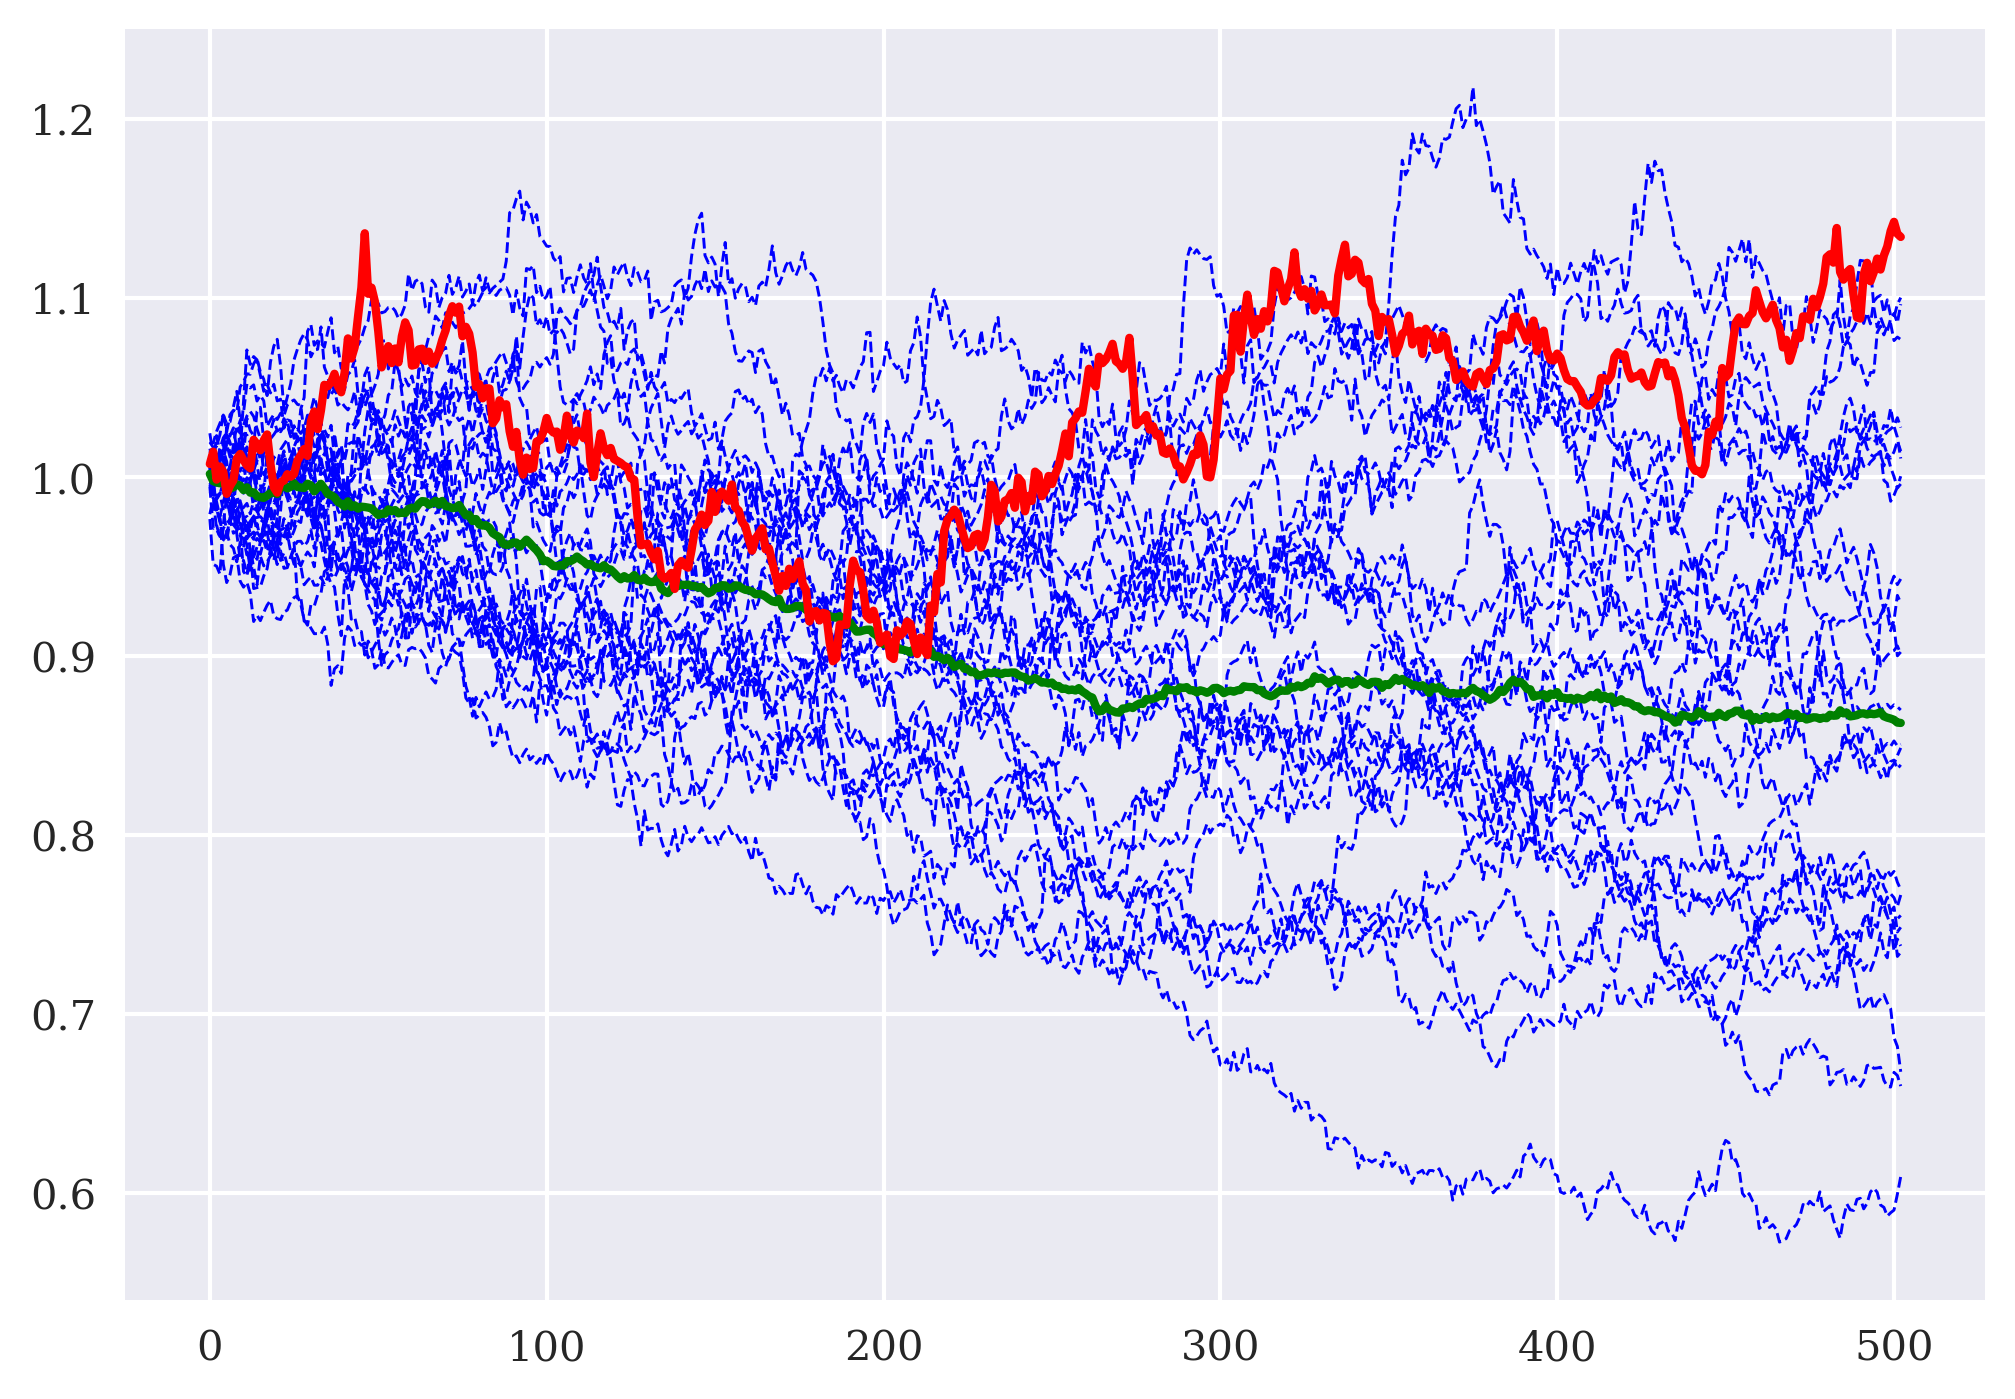

In [38]:
sn = N
data.iloc[:, 1:sn + 1].cumsum().apply(np.exp).plot(
    style='b--', lw=0.7, legend=False)
data.iloc[:, 1:sn + 1].mean(axis=1).cumsum().apply(
    np.exp).plot(style='g', lw=2)
data['real'].cumsum().apply(np.exp).plot(style='r', lw=2);

### Kolmogorow-Smirnow (KS) Test

In [39]:
from scipy import stats

In [40]:
pvs = list()
for i in range(N):
    pvs.append(stats.kstest(data[f'synth_{i:02d}'],
                            data['real']).pvalue)
pvs = np.array(pvs)

In [41]:
np.sort((pvs > 0.05).astype(int))

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1])

In [42]:
sum(np.sort(pvs > 0.05)) / N

1.0

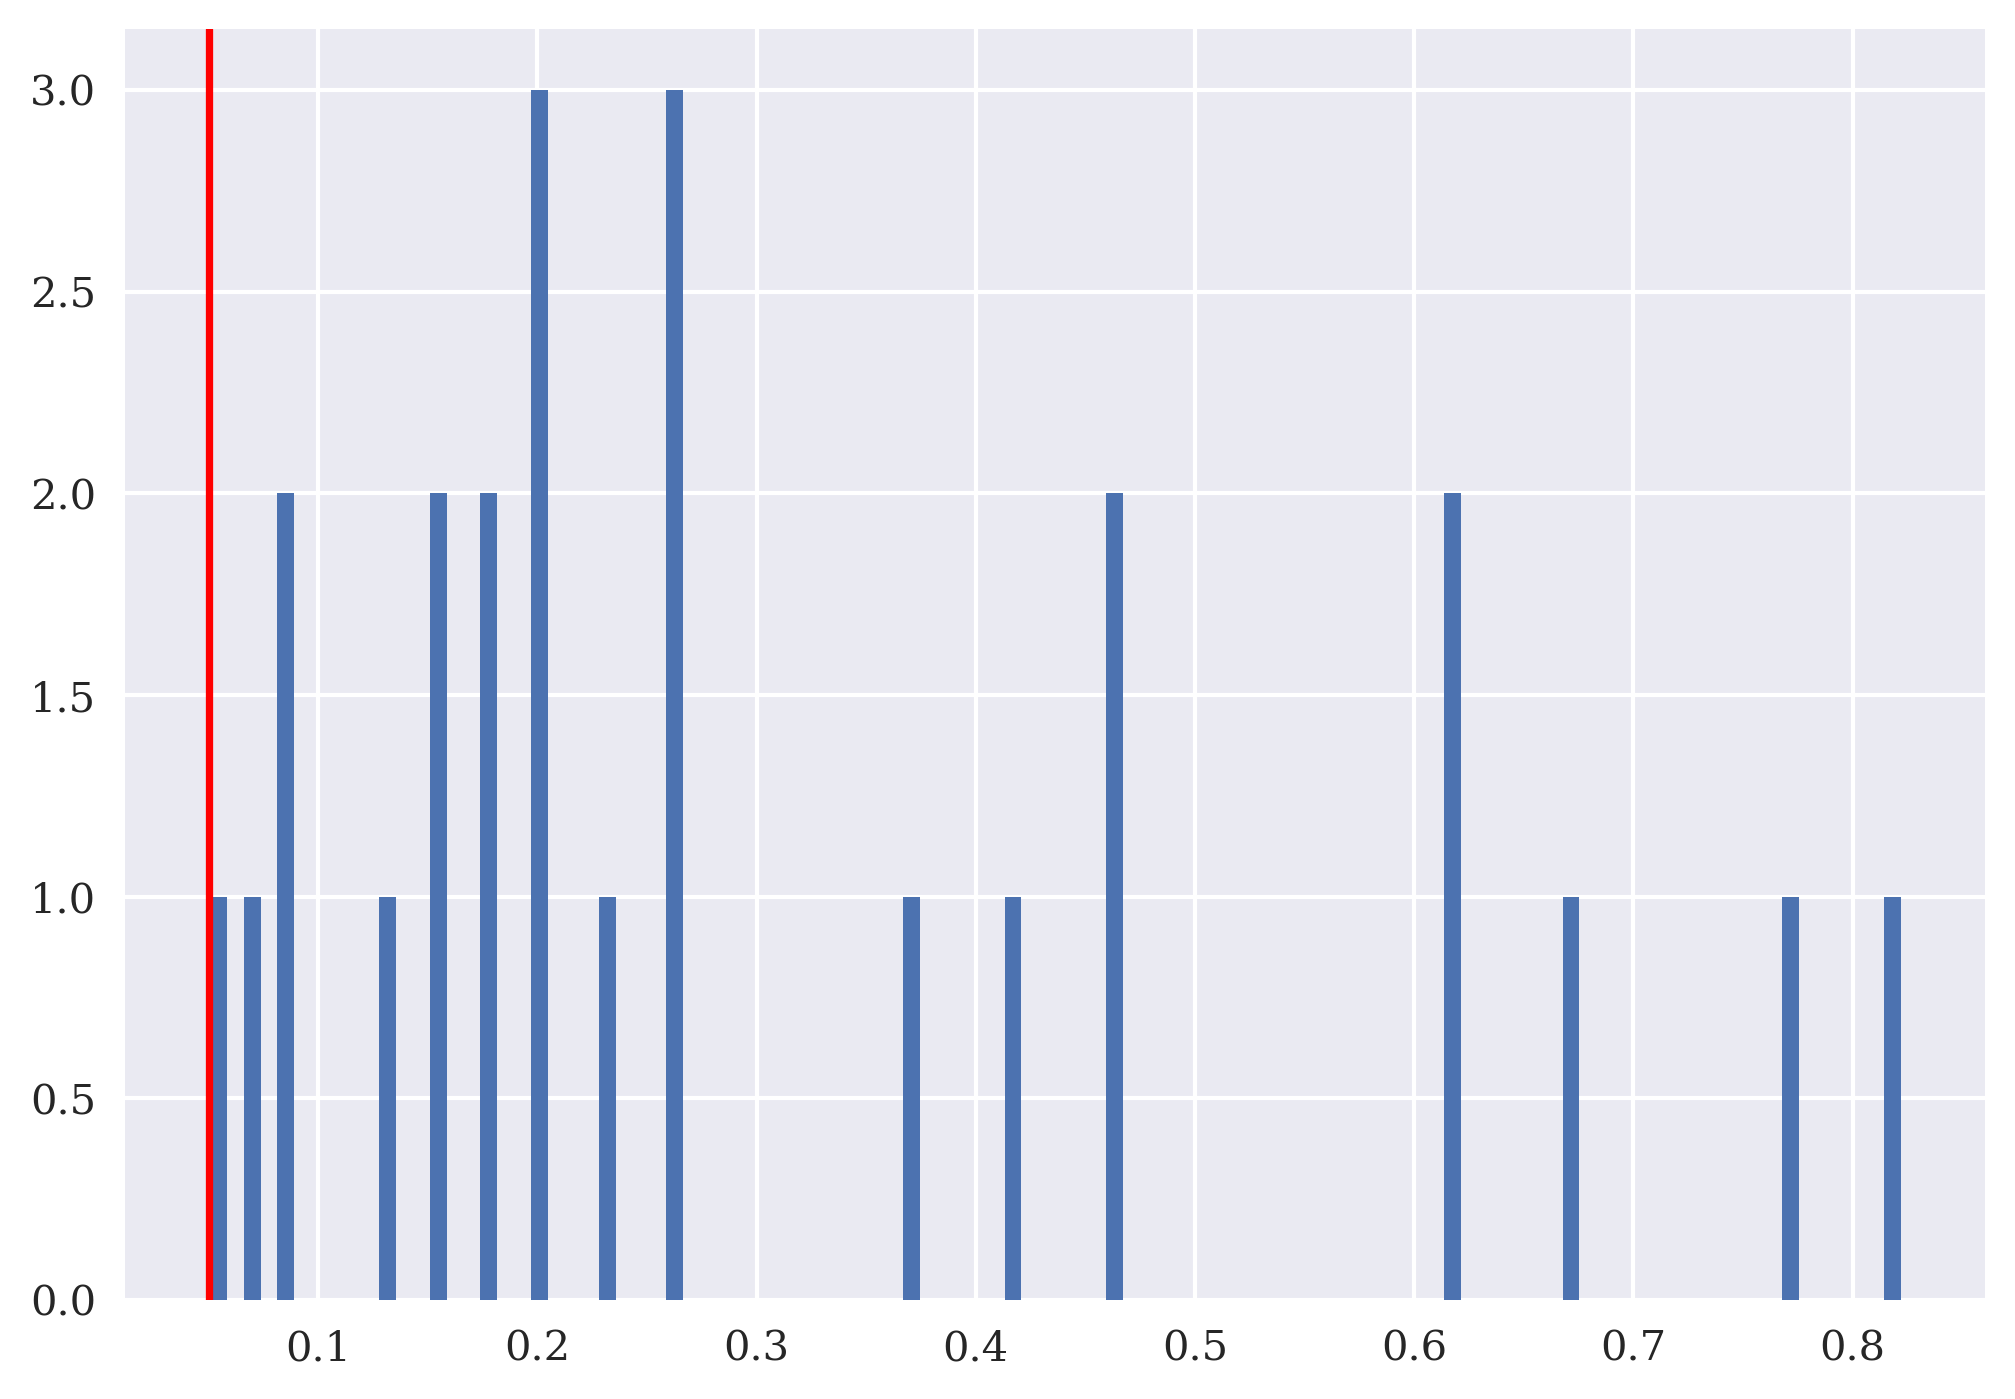

In [43]:
plt.hist(pvs, bins=100)
plt.axvline(0.05, color='r');

<img src="https://hilpisch.com/tpq_logo.png" alt="The Python Quants" width="35%" align="right" border="0"><br>

<a href="https://tpq.io" target="_blank">https://tpq.io</a> | <a href="https://twitter.com/dyjh" target="_blank">@dyjh</a> | <a href="mailto:team@tpq.io">team@tpq.io</a>

## Summary: Advanced Data Generation with GANs

This notebook introduced **Generative Adversarial Networks** as a powerful tool for creating synthetic financial data - representing a major advancement in quantitative finance methodology:

### Key Technical Achievements:

**1. GAN Architecture Mastery:**
- **Generator networks**: Transform random noise into realistic data
- **Discriminator networks**: Distinguish real from synthetic data
- **Adversarial training**: Two networks competing to improve each other
- **Architecture design**: Optimal network sizes for different data types

**2. Progressive Learning Approach:**
- **Simple start**: Mathematical function (x³) for concept understanding
- **Real application**: Gold ETF returns for practical validation
- **Scaling up**: From 5 to 25 synthetic datasets for robust testing
- **Quality assessment**: Multiple validation methods

**3. Financial Data Characteristics:**
- **Return modeling**: Capturing volatility clustering and fat tails
- **Distribution preservation**: Maintaining statistical properties
- **Temporal structure**: Realistic time series behavior
- **Extreme events**: Proper representation of market crashes/spikes

### Validation Methodology:

**1. Visual Inspection:**
- **Time series plots**: Do synthetic returns look realistic?
- **Distribution comparison**: Histograms and Q-Q plots
- **Cumulative performance**: Price path reconstruction

**2. Statistical Testing:**
- **Descriptive statistics**: Moments and percentiles comparison
- **Kolmogorov-Smirnov tests**: Rigorous distribution comparison
- **P-value analysis**: Quantitative validation framework

**3. Financial Relevance:**
- **Portfolio simulation**: Using synthetic data for investment strategies
- **Risk modeling**: Stress testing with generated scenarios
- **Model training**: Augmented datasets for machine learning

### Applications in Quantitative Finance:

**1. Risk Management:**
- **Monte Carlo simulations**: Thousands of realistic market scenarios
- **Value-at-Risk**: Better tail risk estimation with synthetic data
- **Stress testing**: Extreme scenarios for portfolio robustness

**2. Algorithmic Trading:**
- **Strategy backtesting**: Extended historical data for validation
- **Model training**: More diverse datasets for machine learning
- **Regime modeling**: Generate data for different market conditions

**3. Research and Development:**
- **Academic studies**: Reproducible experiments with controlled data
- **Product development**: Safe testing environment without real market risk
- **Regulatory compliance**: Demonstrate strategy robustness with synthetic scenarios

### Advantages Over Traditional Simulation:

**Traditional Methods (e.g., Notebook 4):**
- Require parametric assumptions
- Limited to known mathematical models
- May miss complex patterns in real data

**GAN Methods (This Notebook):**
- Learn directly from data
- Capture unknown patterns and dependencies
- No distributional assumptions required
- More flexible and adaptive

### Real-World Impact:

**1. Data Privacy:**
- Generate realistic datasets without exposing proprietary information
- Enable research collaboration without sharing sensitive data
- Comply with regulations while maintaining data utility

**2. Cost Reduction:**
- Reduce need for expensive market data subscriptions
- Generate unlimited training data for algorithm development
- Enable extensive testing without market risk

**3. Innovation Enablement:**
- Support development of new trading strategies
- Enable research into extreme market conditions
- Facilitate AI/ML advancement in finance

### The Learning Journey:

- **Notebook 1**: Basic RL concepts with simple examples
- **Notebook 2**: Deep Q-Learning with game environments
- **Notebook 3**: Real market data application
- **Notebook 4**: Mathematical simulation and controlled experiments
- **Notebook 5**: Advanced data generation with neural networks

### Future Directions:

This GAN foundation enables:
- **Conditional GANs**: Generate data conditioned on market regimes
- **Time series GANs**: Better temporal dependency modeling
- **Multi-asset GANs**: Generate correlated returns across instruments
- **High-frequency GANs**: Microsecond-level market data generation
- **Cross-modal GANs**: Generate both price and news data simultaneously

**The Revolution in Financial Data:**
GANs represent a paradigm shift from "modeling what we think markets should do" to "learning what markets actually do" and then generating unlimited realistic scenarios. This is transforming how quantitative analysts develop, test, and deploy trading strategies.

The ability to generate unlimited, realistic financial data democratizes quantitative finance research and enables more robust, better-tested trading algorithms.